In [1]:
from biopandas.pdb import PandasPdb #libreria para trabajar con .pdb
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import scipy.fftpack as fourier
from statistics import mean
from scipy.stats import poisson
from scipy.linalg import expm
from scipy.special import erf
import math
import statistics
import os
from scipy.stats import linregress

# Crea redes de residuos de proteínas de los archivos pdb de un directorio (75 Mpro de SARS CoV 2) , calcula sus metricas promedio y genera graficas

# Crea una red G en base a un archivo pdb

In [2]:
def G_Pro1(D, pdb_file,file):
    # Lee el archivo PDB y convierte los datos en un DataFrame
    
    df = PandasPdb().read_pdb(pdb_file)

    # Filtra solo los carbonos alfa y toma solo el primero de cada residuo
    df_ca = df.df['ATOM'][df.df['ATOM']['atom_name'] == 'CA']
    df_ca = df_ca.groupby('residue_number').first().reset_index()
    
    # Filtra los residuos que se van a omitir(esto por que la mayoria de pdb s no toman en cuanra los atomos de los etremos de la proteina)
    df_ca = df_ca[~df_ca['residue_number'].isin([1, 2]) & ~df_ca['residue_number'].between(301, 306)]

    # Calcula la matriz de distancia entre los carbonos alfa
    distances = cdist(df_ca[['x_coord', 'y_coord', 'z_coord']], df_ca[['x_coord', 'y_coord', 'z_coord']])

    # Encuentra las parejas de carbonos alfa que están a menos de 7 Ångstroms
    ca_combinations = combinations(range(len(distances)), 2)
    ca_pairs = [(df_ca.iloc[i]['residue_number']-3, df_ca.iloc[j]['residue_number']-3)
                for i, j in ca_combinations if distances[i][j] < 7]

    # Obtener el número de nodos
    nodos = list(set(sum(ca_pairs, ())))
    num_nodos = len(nodos)

    # Crear una matriz de ceros de tamaño num_nodos x num_nodos
    matriz = np.zeros((num_nodos, num_nodos))

    # Llenar la matriz con las conexiones
    for conexion in ca_pairs:
        i = nodos.index(conexion[0])
        j = nodos.index(conexion[1])
        matriz[i][j] = 1
        matriz[j][i] = 1

    # Crea un objeto Graph de networkx y agrega los nodos y las aristas a partir de la matriz de adyacencia
    GMpro1 = nx.Graph(matriz)

    # Imprimir el resultado del numero de nodos para cada archivo
    print("El número de nodos de la red", file ,"es:", num_nodos)

    return GMpro1


# Calcula las métricas de la red 


In [3]:
#redondea las componentes de la matriz para evitar errores
def redondear_matriz(matriz, cifras_decimales):
    matriz_numerica = np.array(matriz, dtype=float)  # Convertir la matriz a tipo float
    matriz_redondeada = np.round(matriz_numerica, cifras_decimales)
    return matriz_redondeada
#funcion doble factorial
def double_factorial(k):
    if k <= 0:
        return 1
    else:
        return k * double_factorial(k-2) if k <= 19 else math.prod(range(k, 0, -2))
#funcion matriz de centralidad subgrafica de largo alcance, kmax es el numero de interaciones de la sumatoria  
#se utiliza el metodo de sumatoria
def MZ(G, k_max):
    A = nx.adjacency_matrix(G).todense()
    suma = np.identity(A.shape[0], dtype=float)
    potencia_A = np.identity(A.shape[0], dtype=float)
    suma_values = []  # Lista para almacenar los valores de suma
    for k in range(1, k_max+1):
        df = double_factorial(int(k))
        potencia_A = np.matmul(potencia_A, A)
        #print(potencia_A)
        suma += redondear_matriz(potencia_A/df, 10)
        
    return suma
#funcion matriz de centralidad subgrafica,kmax es el numero de interaciones de la sumatoria
#se utiliza el metodo de sumatoria
def MG(G, k_max):
    A = nx.adjacency_matrix(G).todense()
    suma = np.identity(A.shape[0], dtype=float)
    potencia_A = np.identity(A.shape[0], dtype=float)
    suma_values = []  # Lista para almacenar los valores de suma
    for k in range(1, k_max+1):
        df = math.factorial(int(k))       
        potencia_A = np.matmul(potencia_A, A)
        #print(potencia_A)
        suma += redondear_matriz(potencia_A/df, 10)
     
    
    return suma
#Calcula diversas centralidades para cada red
def centralidad(G):
    
    # Calcula la densidad de la red
    density = nx.density(G)
    

    #Calcula el grado de heterogeneidad de la red G.
   
    n = len(G.nodes())
    het_sum = 0.0

    for node in G.nodes:
        for neighbor in G.neighbors(node):
            if node < neighbor:  # para evitar parejas duplicadas
                degree_node = G.degree(node)
                degree_neighbor = G.degree(neighbor)
                het_sum += (degree_node**(-0.5) - degree_neighbor**(-0.5))**2
                #print(f"({node}, {neighbor}): ({degree_node**(-0.5)}, {degree_neighbor**(-0.5)},{(degree_node**(-0.5) - degree_neighbor**(-0.5))**2})")

    het_sum = het_sum/(nx.number_of_nodes(G)-2*(nx.number_of_nodes(G)-1)**0.5) #normalizando
    
    # Calcula la centralidad de eigenvalor de cada nodo de la red:
    
    eigen_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    
    # Promedio de la centralidad de eigenvalor 
    
    average_eigen_centrality = sum(eigen_centrality.values()) / n

    
    # Calcula la longitud media del camino
    average_path_length = nx.average_shortest_path_length(G)
    
    # Calcular el promedio de coeficiente de agrupamiento de Watts-Strogatz (clustering coefficient)
    avg_watts_strogatz_cc = nx.average_clustering(G, count_zeros=True)
    
    # Calcular el grado de asociatividad
    
    r=nx.degree_assortativity_coefficient(G)
    
    # Calcula betweenness centrality para cada nodo
    bc = nx.betweenness_centrality(G,normalized=False)

    # Suma los valores de betweenness centrality de todos los nodos
    total_bc = sum(bc.values())

    # Calcula el average betweenness centrality
    avg_bc = total_bc / len(bc)
    
    # Calcula la matriz de centralidad subgrafica de la red, esto es igual a exp(A)  
    
    exp_A = MG(G,25)
    
    # Accede a los elementos de la diagonal de exp_A y calcula su media
    avg_diag = np.mean(np.diag(exp_A))
    
    # Promedia todas las entradas de exp_A excepto la diagonal, esto es la comunicabilidad 
    avg_c = np.mean(exp_A[np.where(~np.eye(exp_A.shape[0], dtype=bool))])  
    
    # Calcula la matriz de centralidad subgrafica de de largo alcance   
    z = MZ(G,150)
    
    # Accede a los elementos de la diagonal de z y calcula su media
    avg_diag_z = np.mean(np.diag(z))
    
    # Promedia todas las entradas de z excepto la diagonal, esto es la comunicabilidad de LR
    avg_z = np.mean(z[np.where(~np.eye(z.shape[0], dtype=bool))])
    
    # Calcula el angulo de comunicabilidad de la matriz A 
    
    # Inicializamos la variable de suma
    suma = 0

    # Recorremos todas las entradas de la matriz A que no están en la diagonal
    for i in range(n):
        for j in range(n):
            if i != j:
                # Calculamos la operación cos a la -1 (Aij/sqrt(Aii*Ajj)) en cada entrada
                suma += math.degrees(np.arccos(exp_A[i,j]/np.sqrt(exp_A[i,i]*exp_A[j,j])))


    # Calculamos el promedio de todas las operaciones
    Angulo = suma/(n*(n-1))  
    
    return  density,het_sum,average_path_length,avg_watts_strogatz_cc,r,avg_bc,average_eigen_centrality,avg_diag,avg_c,Angulo, avg_diag_z,avg_z

# Grafica Nodo vs Centralidad Subgrafica (diagonal de MG y MZ) por medio de matrices G y Z de centralidad cada red.  

In [4]:
#centralidad Subgrafica promedio de las redes (elementos en la diagonal de la matriz G)
def centralidad_sub(MGs):
    n = len(MGs[0])
    # Creamos una lista vacía para almacenar los elementos diagonales 
    elementos_diagonal = [0] * n
    desviaciones_estandar = [0] * n

    # Iteramos sobre las diagonales de las matrices
    for i in range(n):
        # Obtenemos los elementos diagonales correspondientes
        diagonal_elements = [G[i, i] for G in MGs]
        # Calculamos el promedio de los elementos diagonales correspondientes
        promedio_diagonal = np.mean(diagonal_elements)
        desviacion_estandar = np.std(diagonal_elements)
        # Agregamos el promedio y la desviación estándar a las listas correspondientes
        elementos_diagonal[i] = promedio_diagonal
        desviaciones_estandar[i] = desviacion_estandar
       

    # Graficamos los promedios en función del número de elemento en la diagonal
    num_elementos = n
    plt.figure(figsize=(20,10)) 
    plt.plot(range(1, num_elementos + 1), elementos_diagonal, '-o')
    #plt.errorbar(range(1, num_elementos + 1), elementos_diagonal, yerr=desviaciones_estandar, fmt='o',color='red',markerfacecolor='red', ecolor='blue',capsize=5)
    plt.xlim(0,300)
    plt.legend()  
    plt.xlabel('Residuo')
    plt.ylabel('Centralidad subgrafica')
    plt.title("Centralidad subgrafica promedio")
    #plt.savefig('Centralidad sub prom 75 redes', dpi=200) 
    # Mostrar la gráfica
    plt.show()
#centralidad Subgrafica de las m primeras redes (elementos en la diagonal de la matriz G)
def centralidad_n(MGs,m):
    n = len(MGs[0])
    plt.figure(figsize=(20,10))
    # Iterar sobre las primeras n redes
    for j in range(m):
        diagonal_elements = [MGs[j][i, i] for i in range(n)]
        
        # Graficar los elementos de la diagonal de la red j
        plt.plot(range(n), diagonal_elements, label=f"Red {j+1}")
        
    # Configurar la leyenda y el título de la gráfica
    plt.xlim(0,300) 
    plt.legend()
    plt.xlabel('Residuo')
    plt.ylabel('Centralidad subgrafica')
    plt.title("Centralidad subgrafica de las primeras m redes")
    #plt.savefig('Centralidad sub de m redes', dpi=200) 
    # Mostrar la gráfica
    plt.show()
#centralidad Subgrafica de Largo Alcance promedio de las redes (elementos fuera de la diagonal de la matriz Z)
def LR_centralidad_sub(MZs):
    n = len(MZs[0])
    # Creamos una lista vacía para almacenar los elementos diagonales
    elementos_diagonal = [0] * n
    desviaciones_estandar = [0] * n

    # Iteramos sobre las diagonales de las matrices
    for i in range(n):
        # Obtenemos los elementos diagonales correspondientes
        diagonal_elements = [Z[i, i] for Z in MZs]
        # Calculamos el promedio de los elementos diagonales correspondientes
        promedio_diagonal = np.mean(diagonal_elements)
        desviacion_estandar = np.std(diagonal_elements)
        # Agregamos el promedio y la desviación estándar a las listas correspondientes
        elementos_diagonal[i] = promedio_diagonal
        desviaciones_estandar[i] = desviacion_estandar
       

    # Graficamos los promedios en función del número de elemento en la diagonal
    num_elementos = n
    plt.figure(figsize=(20,10)) 
    plt.plot(range(1, num_elementos + 1), elementos_diagonal, '-o')
    #plt.errorbar(range(1, num_elementos + 1), elementos_diagonal, yerr=desviaciones_estandar, fmt='o',color='red',markerfacecolor='red', ecolor='blue',capsize=5)
    plt.xlim(0,300)
    plt.legend()  
    plt.xlabel('Residuo')
    plt.ylabel('Centralidad subgrafica de LA')
    plt.title("Centralidad subgrafica promedio de LA")
    #plt.savefig('Centralidad sub prom de LA de 75 redes, dpi=200) 
    plt.show()
# ditribucion centralidad Subgrafica de Largo Alcance promedio de las redes
def LR_centralidad_sub_dist(MZs):
    n = len(MZs[0])
    elementos_diagonal = []

    for i in range(n):
        diagonal_elements = [Z[i, i] for Z in MZs]
        promedio_diagonal = np.mean(diagonal_elements)
        elementos_diagonal.append(promedio_diagonal)
       
    plt.figure(figsize=(20, 10))
    plt.hist(elementos_diagonal, bins=20, color='blue', edgecolor='black', log=True)  # Escala logarítmica
    plt.xlabel('Centralidad subgrafica de LA')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Frecuencia de Centralidades Subgráficas de LA (Escala Logarítmica)')
    plt.grid(True)
    plt.show()    

# centralidad Subgrafica de Largo Alcance de las m primeras redes (elementos fuera de la diagonal de la matriz Z)     
def centralidad_LR_n(MZs,m):
    n = len(MZs[0])
    plt.figure(figsize=(20,10))
    # Iterar sobre las primeras n redes
    for j in range(m):
        diagonal_elements = [MZs[j][i, i] for i in range(n)]
        
        # Graficar los elementos de la diagonal de la red j
        plt.plot(range(n), diagonal_elements, label=f"Red {j+1}")
        
    # Configurar la leyenda y el título de la gráfica
    plt.xlim(0,300) 
    plt.legend()
    plt.xlabel('Residuo')
    plt.ylabel('Centralidad subgrafica de LA')
    plt.title("Centralidad subgrafica de LA de las primeras m redes")
    #plt.savefig('Centralidad sub de LA de m redes', dpi=200)
    # Mostrar la gráfica
    plt.show()  

# Crea las matrices G y Z para un radio de corte D y en base a los archivos pdb en un directorio dado.

In [5]:
D = 7.0 # radio de corte para residuos

# Directorio que contiene los archivos pdb
dir_path = "pdb_Mpro"

# Obtener una lista de todos los archivos pdb en la carpeta
pdb_files = [f for f in os.listdir(dir_path) if f.endswith('.pdb')]

# Crear la lista de redes
redes = []
for pdb_file in pdb_files:
    red = G_Pro1(D, os.path.join(dir_path, pdb_file),pdb_file)
    redes.append(red)
    
# Crear la lista de matrices Z
MZs = []
for red in redes:
    Z = MZ(red,150)
    MZs.append(Z)    

    
# Crear la lista de matrices G, imprime el numero de nodos de la red de cada archivo pdb
MGs = []
for red in redes:
    G = MG(red,25)
    MGs.append(G)      

El número de nodos de la red 5r84.pdb es: 298
El número de nodos de la red 5re9.pdb es: 298
El número de nodos de la red 5reb.pdb es: 298
El número de nodos de la red 5rei.pdb es: 298
El número de nodos de la red 5rek.pdb es: 298
El número de nodos de la red 5res.pdb es: 298
El número de nodos de la red 5reu.pdb es: 298
El número de nodos de la red 5rfm.pdb es: 298
El número de nodos de la red 5rfp.pdb es: 298
El número de nodos de la red 5rfr.pdb es: 298
El número de nodos de la red 6w63.pdb es: 298
El número de nodos de la red 6wnp.pdb es: 298
El número de nodos de la red 6xqs.pdb es: 298
El número de nodos de la red 6xqu.pdb es: 298
El número de nodos de la red 6xr3.pdb es: 298
El número de nodos de la red 7a1u.pdb es: 298
El número de nodos de la red 7aeh.pdb es: 298
El número de nodos de la red 7aqj.pdb es: 298
El número de nodos de la red 7ar6.pdb es: 298
El número de nodos de la red 7au4.pdb es: 298
El número de nodos de la red 7aws.pdb es: 298
El número de nodos de la red 7ax6.

In [6]:
# Promedio de centralidad de las redes. 
promedio_final = tuple(statistics.mean(sublista) for sublista in zip(*[centralidad(red)[0:] for red in redes]))

# Crea una lista de los nombres de centralidades que se van a promediar en orden
nombres_centralidades = ["Densidad de la red\t", "Heterogeneidad de la red", "Longitud de camino medio",
                        "Coeficiente de agrupamiento", "Coeficiente de asociatividad",
                        "centralidad de intermediación","centralidad de eigenvalor","Centralidad subgrafica\t",
                        "Comunicabilidad\t\t","Angulo de comunicabilidad","Centralidad subgrafica LR",
                        "Comunicabilidad de LR\t"]

# Imprime la tabla con los nombres de centralidades y los promedios calculados
print("Tabla de Centralidades y Promedios")
print("Centralidad\t\t\t\tPromedio")
for nombre, promedio in zip(nombres_centralidades, promedio_final):
    print(f"{nombre}\t\t{promedio}")

Tabla de Centralidades y Promedios
Centralidad				Promedio
Densidad de la red			0.026168018740725676
Heterogeneidad de la red		0.016393832782632105
Longitud de camino medio		6.292620161344994
Coeficiente de agrupamiento		0.5405110892090759
Coeficiente de asociatividad		0.3927013455881912
centralidad de intermediación		785.9540939597317
centralidad de eigenvalor		0.0325913275276883
Centralidad subgrafica			180.82092571773447
Comunicabilidad				24.19257603783636
Angulo de comunicabilidad		82.05598700018199
Centralidad subgrafica LR		3.075944605081518e+18
Comunicabilidad de LR			9.175073926205902e+17


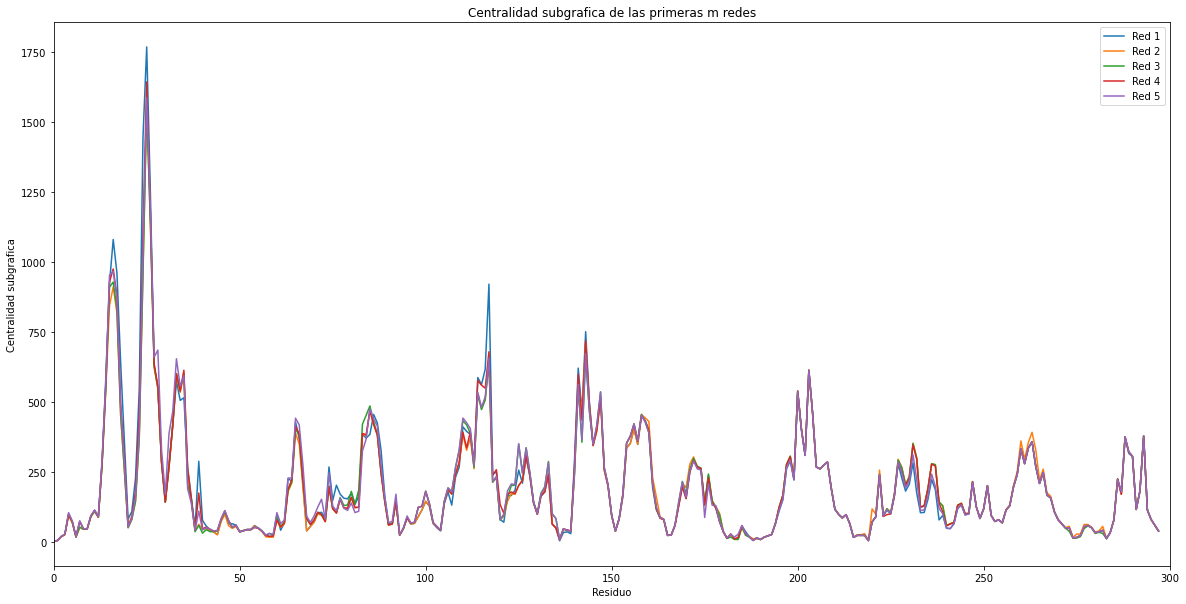

In [7]:
# Obtenemos la centralidad de subgrafica
centralidad_n(MGs,5)

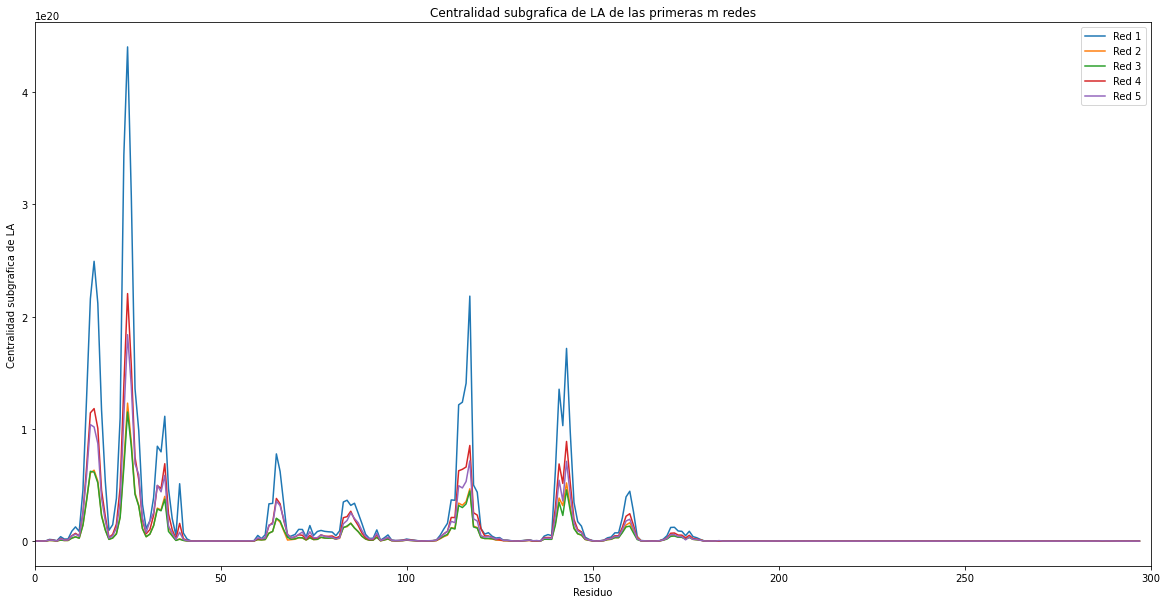

In [8]:
centralidad_LR_n(MZs,5)

No handles with labels found to put in legend.


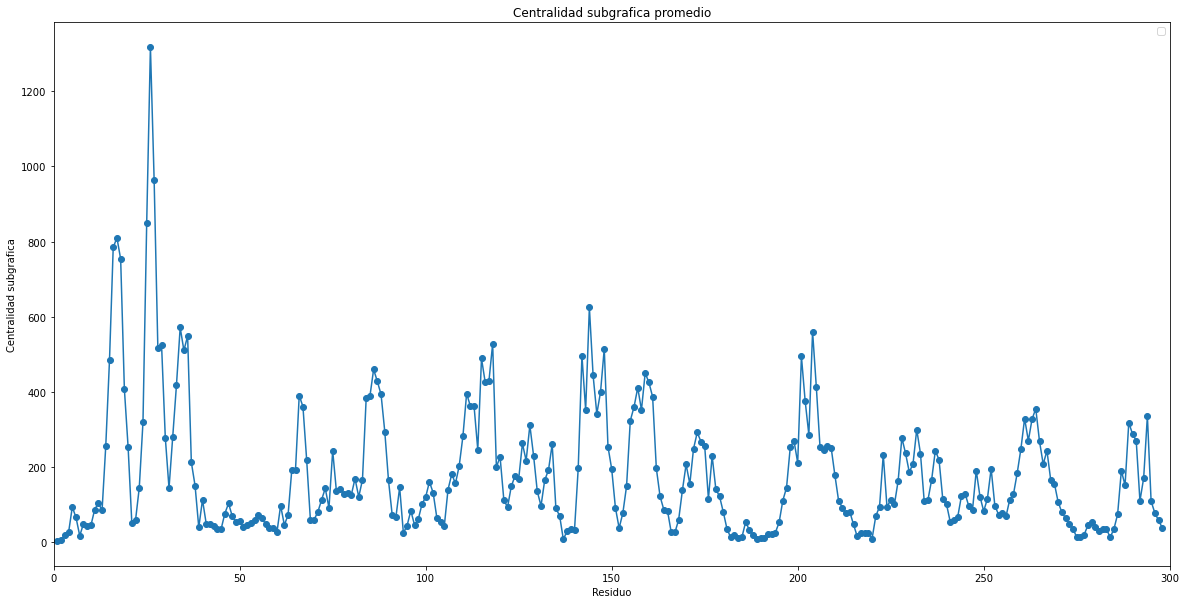

In [9]:
# Obtenemos la centralidad de subgrafica promedio
centralidad_sub(MGs)

No handles with labels found to put in legend.


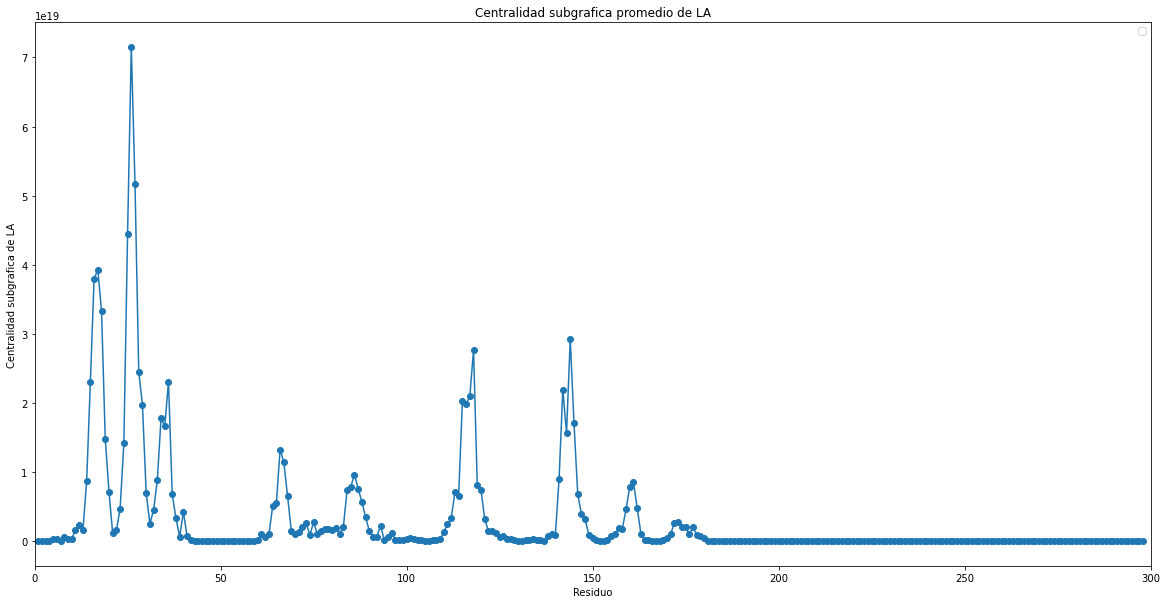

In [10]:
# Obtenemos la centralidad de subgrafica de largo alcance LA promedio
LR_centralidad_sub(MZs)

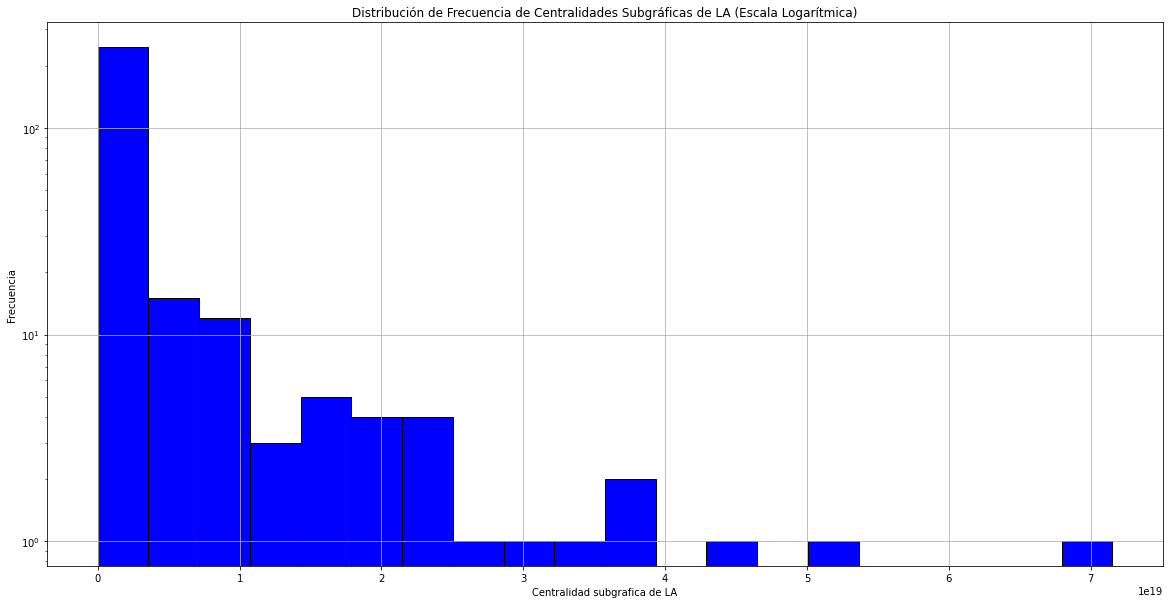

In [11]:
LR_centralidad_sub_dist(MZs)

# Ranking de nodos con maxima centralidad Subgrafica de las n primeras matrices G. 

In [12]:
def max_diagonal_elements(MGs):
    max_values = []
    #encontra los nodos con mayor centralidad de las n=3 primeras matrices G
    for j in range(3):
        diagonal_elements = [MGs[j][i, i] for i in range(len(MGs[j]))]
        # Ordenamos los valores diagonales en orden descendente
        diagonal_sorted = np.sort(diagonal_elements)[::-1]
        # Tomamos los índices de los 10 mayores valores diagonales
        top_indices = np.argsort(diagonal_elements)[::-1][:10]
        max_values.append(top_indices)
    return max_values

max_values = max_diagonal_elements(MGs)
print(max_values)

[array([ 25,  24,  26,  16,  17,  15, 117, 143,  18,  27], dtype=int64), array([ 25,  26,  24,  16,  15,  17, 143, 117,  27, 203], dtype=int64), array([ 25,  26,  24,  16,  15,  17, 143, 117,  27, 203], dtype=int64)]


# Ranking de nodos con maxima centralidad Subgrafica de Largo Alcance (LR) las matrices Z. 

In [13]:
def max_diagonal_prom(MZs):
    max_values = []
    n = len(MZs[0])
    # Creamos una lista vacía para almacenar los elementos diagonales
    elementos_diagonal = [0] * n
        
    for i in range(n):
        # Obtenemos los elementos diagonales correspondientes
        diagonal_elements = [Z[i, i] for Z in MZs]
        # Calculamos el promedio de los elementos diagonales correspondientes
        promedio_diagonal = np.mean(diagonal_elements)
        # Agregamos el promedio a las lista correspondiente
        elementos_diagonal[i] = promedio_diagonal
    #print(elementos_diagonal)    
    # Ordenamos los valores diagonales en orden descendente
    diagonal_sorted = np.sort(elementos_diagonal)[::-1]
    # Tomamos los índices de los 22 mayores valores diagonales, el 3 es para coincidir con el numero de reciduo de la proteina
    top_indices = np.argsort(elementos_diagonal)[::-1][:22]+3
    max_values.append(top_indices)
    return max_values

max_values = max_diagonal_prom(MZs)
print(max_values)

[array([ 28,  29,  27,  19,  18,  20, 146, 120,  30,  38,  17, 144, 119,
       117, 118,  31,  36, 147,  37, 145,  21,  26], dtype=int64)]


# Grafica de centralida subgrafica promedio

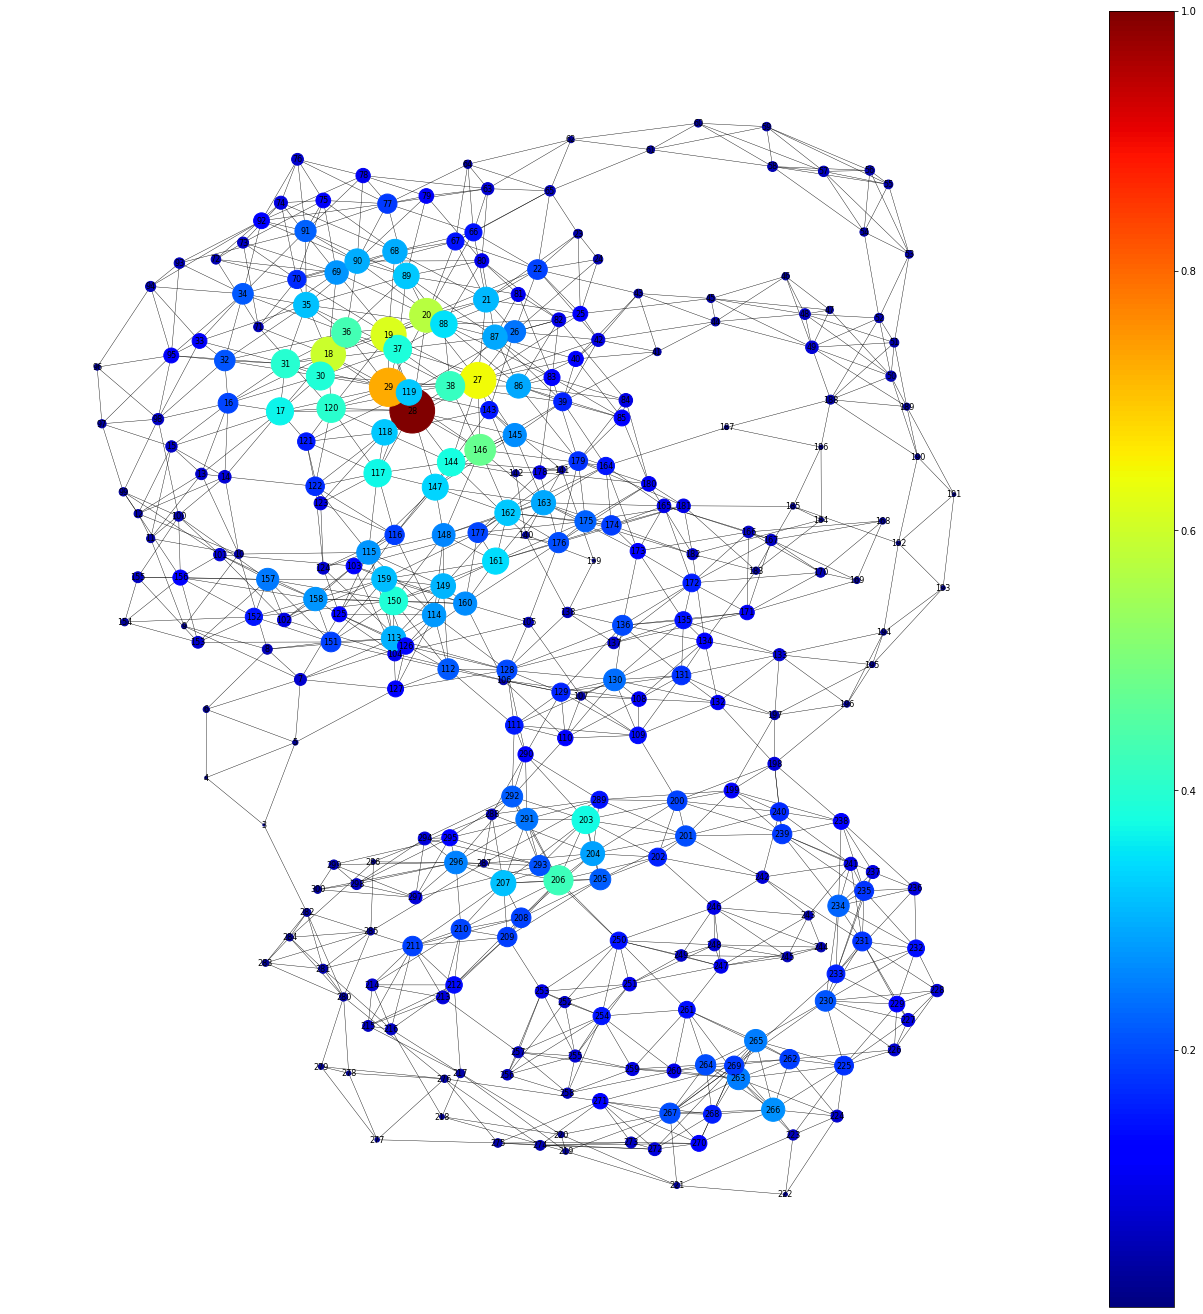

In [14]:
# Calcular los valores promedio de la diagonal de cada matriz G
diagonal_means = np.mean([np.diag(G) for G in MGs], axis=0)

# Normalizar los valores promedio de la diagonal
diagonal_means_norm = diagonal_means / np.max(diagonal_means)

# Crear un mapeo para la nueva numeración de los nodos
mapping = {n: n + 3 for n in red.nodes()}

# Obtener la red con la numeración de los nodos modificada
red_numerada = nx.relabel_nodes(red, mapping)

# Graficar la red con la nueva numeración de los nodos
plt.figure(1, figsize=(18, 18))
nx.draw_kamada_kawai(red_numerada, node_size=diagonal_means_norm*2000, cmap=plt.cm.jet, node_color=diagonal_means_norm, width=0.4, font_size=8, with_labels=True, font_color="Black")
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=min(diagonal_means_norm), vmax=max(diagonal_means_norm)))
sm.set_array([])
plt.colorbar(sm)


#plt.savefig('Centralidad subgrafica prom 75 redes', dpi=200) 
plt.show()


# Grafica de centralida subgrafica de LR promedio

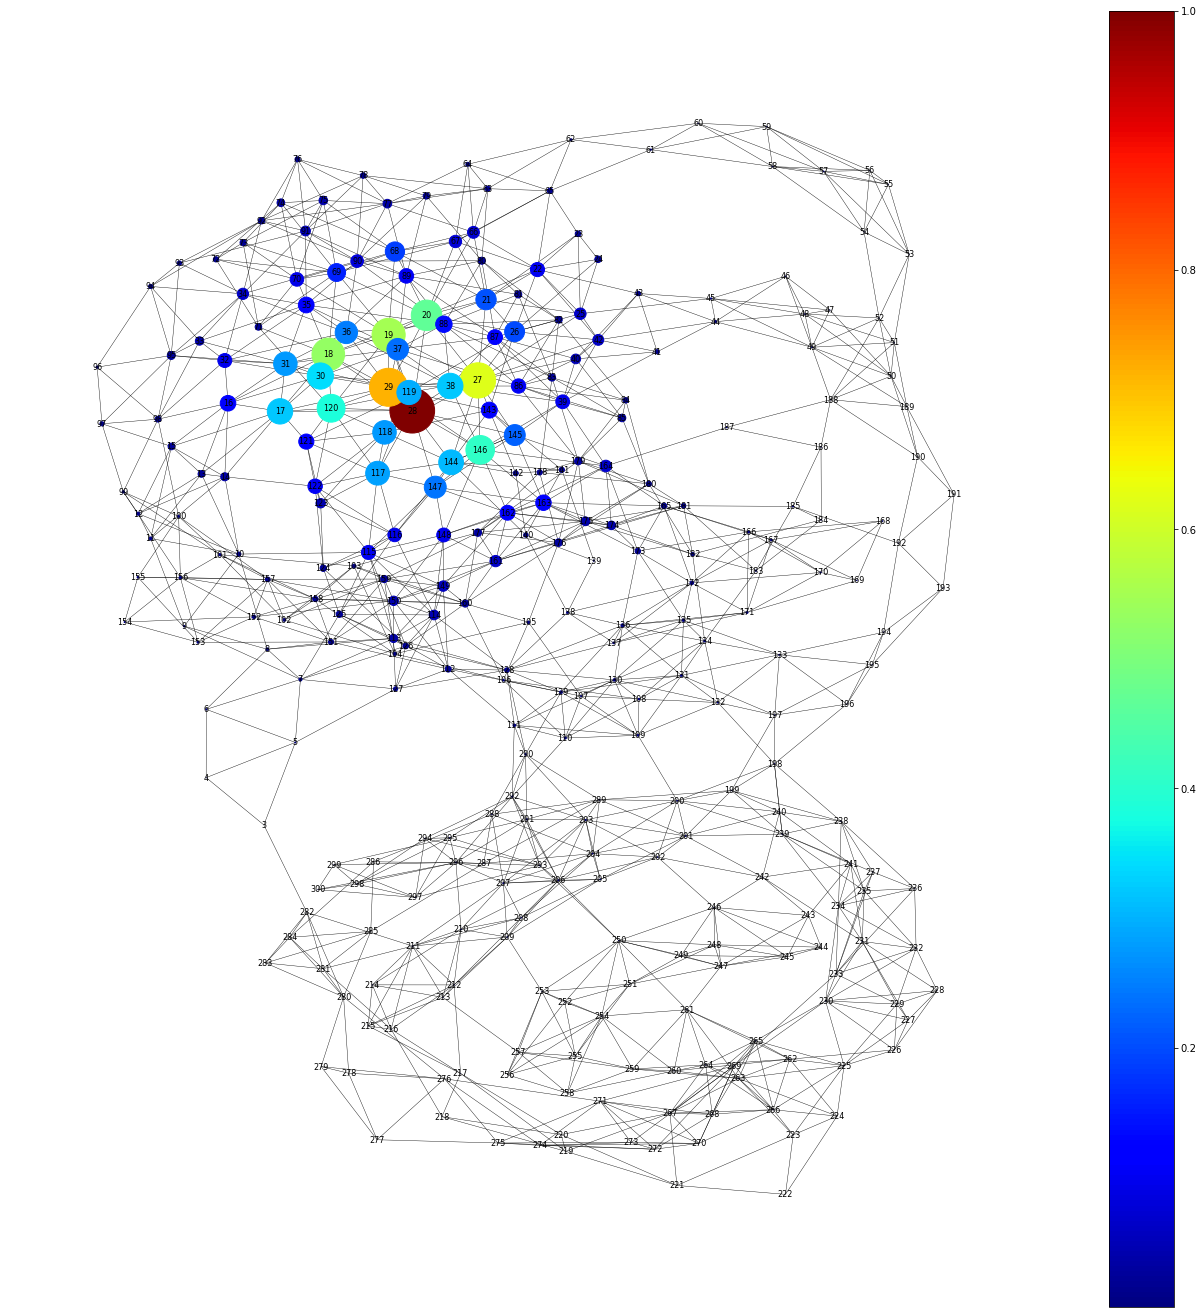

In [15]:
# Calcular los valores promedio de la diagonal de cada matriz Z
diagonal_means = np.mean([np.diag(Z) for Z in MZs], axis=0)

# Normalizar los valores promedio de la diagonal
diagonal_means_norm = diagonal_means / np.max(diagonal_means)

# Crear un mapeo para la nueva numeración de los nodos
mapping = {n: n + 3 for n in red.nodes()}

# Obtener la red con la numeración de los nodos modificada
red_numerada = nx.relabel_nodes(red, mapping)

# Graficar la red con la nueva numeración de los nodos
plt.figure(1, figsize=(18, 18))
nx.draw_kamada_kawai(red_numerada, node_size=diagonal_means_norm*2000, cmap=plt.cm.jet, node_color=diagonal_means_norm, width=0.4, font_size=8, with_labels=True, font_color="Black")
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=min(diagonal_means_norm), vmax=max(diagonal_means_norm)))
sm.set_array([])
plt.colorbar(sm)

plt.savefig('Centralidad Subgrafica de LR prom 75 redes', dpi=200)
plt.show()

# El programa calcula y muestra el grado promedio de cada nodo en las redes, representado en un gráfico de líneas.

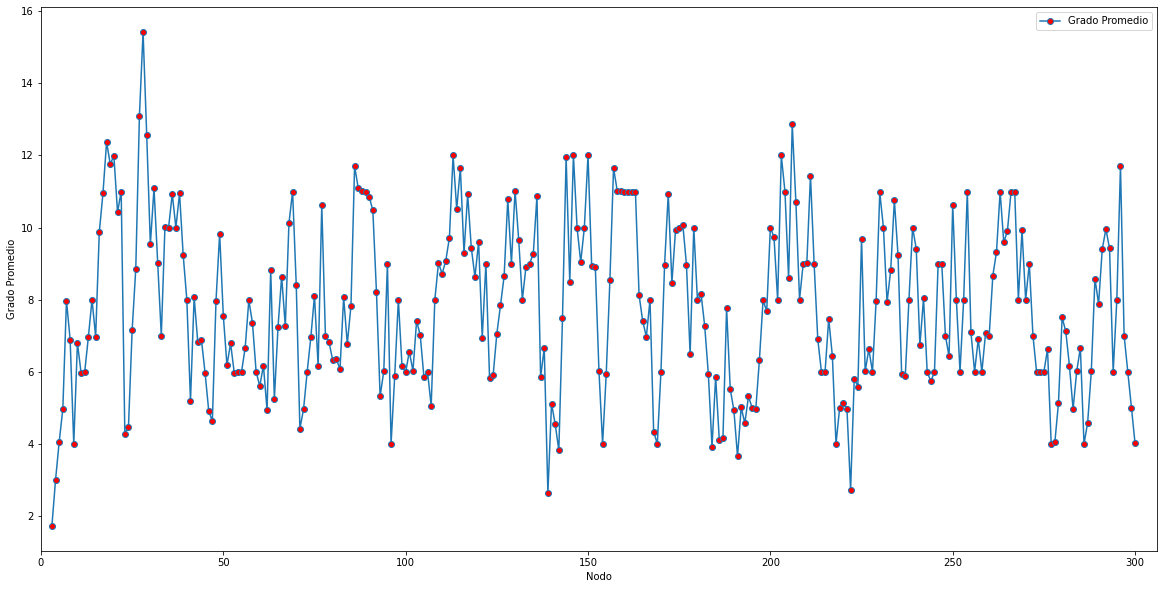

In [16]:
nodos = redes[0].nodes()  # Obtener la lista de nodos de una de las redes
grados_promedio = []

for nodo in nodos:
    grados_nodo = [red.degree(nodo) for red in redes]  # Obtener los grados del nodo en cada red
    grado_promedio = np.mean(grados_nodo)
    grados_promedio.append(grado_promedio)

# Reetiquetar los números de nodo sumando 3 unidades
nodos_reetiquetados = [nodo + 3 for nodo in nodos]

plt.figure(figsize=(20, 10))
plt.ylabel('Grado Promedio')
plt.xlabel('Nodo')
plt.xlim(-0, 306)
plt.plot(nodos_reetiquetados, grados_promedio, '-o', mfc="r", label="Grado Promedio")
plt.legend()
#plt.savefig('Centralidad de Grado Promedio', dpi=200)
plt.show()

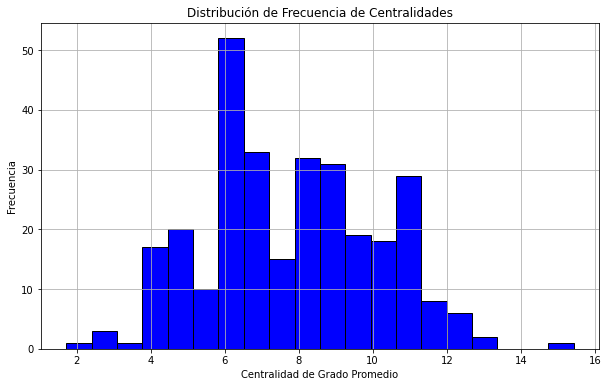

In [17]:
# Crear un histograma de la distribución de frecuencia de las centralidades
plt.figure(figsize=(10, 6))
plt.hist(grados_promedio, bins=20, color='blue', edgecolor='black')
plt.xlabel('Centralidad de Grado Promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencia de Centralidades')
plt.grid(True)
plt.show()


In [18]:
#esta funcion hace un ranking de las 20 mayores centralidades y toma en cuanta los 3 pimeros atomos de la proteina
def top(centrality):  # top 20
    top = list(reversed(sorted((rank, node) for node, rank in centrality.items())))[:20]
    nodos_ranking = [node + 3 for rank, node in top]  # Aumentar en 3 unidades los números de los nodos en el ranking
    return nodos_ranking

In [19]:
#Calcula las 20 mayores centralidades de grado promedio de las redes
nodos = redes[0].nodes()  # Obtener la lista de nodos de una de las redes
grados_promedio = []

for nodo in nodos:
    centralidades_nodo = [nx.degree_centrality(red)[nodo] for red in redes]  # Obtener las centralidades de grado del nodo en cada red
    grado_promedio = np.mean(centralidades_nodo)
    grados_promedio.append(grado_promedio)

# Crear un diccionario de nodos y sus grados promedio
diccionario_grados = {nodo: grado for nodo, grado in zip(nodos, grados_promedio)}

# Obtener los 20 nodos con mayor centralidad de grado
nodos_top_20 = top(diccionario_grados)[:20]

print("Top 20 nodos de mayor centralidad de grado:")
for nodo in nodos_top_20:
    print(nodo)




Top 20 nodos de mayor centralidad de grado:
28
27
206
29
18
203
150
146
113
20
144
19
296
86
157
115
211
87
31
158


In [20]:
# Crear un diccionario de nodos y sus grados promedio
diccionario_grados = {nodo: grado for nodo, grado in zip(nodos, grados_promedio)}

# Obtener los 20 nodos con mayor centralidad de grado
nodos_top_20 = top(diccionario_grados)[:20]
    
# Mostrar la tabla de centralidades de grado para los nodos top 20
print("\nTabla de Centralidades de Grado para los Top 20 Nodos:")
print("Nodo\t\tCentralidad de Grado Promedio")
for nodo in nodos_top_20:
    print(f"{nodo}\t\t{diccionario_grados[nodo-3]}")    


Tabla de Centralidades de Grado para los Top 20 Nodos:
Nodo		Centralidad de Grado Promedio
28		0.05194163860830528
27		0.04408529741863075
206		0.04332210998877665
29		0.04228956228956228
18		0.041661054994388325
203		0.04040404040404039
150		0.04040404040404039
146		0.04040404040404039
113		0.04040404040404039
20		0.040359147025813676
144		0.040269360269360246
19		0.03959595959595959
296		0.03941638608305274
86		0.039416386083052736
157		0.039236812570145906
115		0.0392368125701459
211		0.038518518518518514
87		0.037351290684624026
31		0.037351290684624026
158		0.037126823793490464


# El programa calcula y muestra el grado de cercania de cada nodo en las redes, representado en un gráfico de líneas.

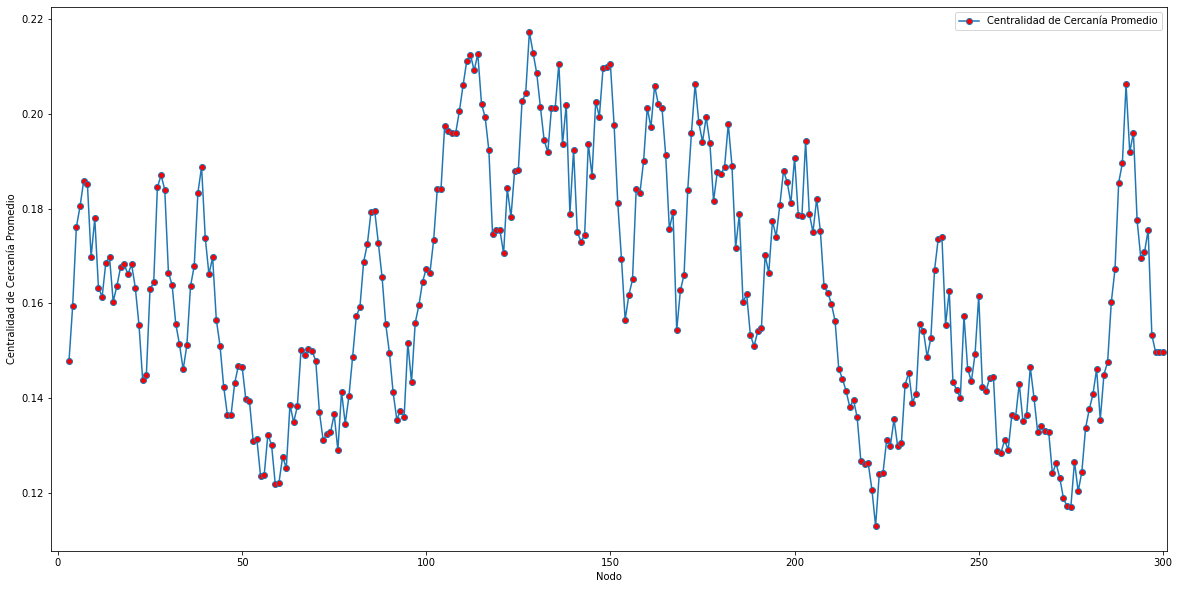

In [21]:
nodos = redes[0].nodes()  # Obtener la lista de nodos de una de las redes
centralidades_promedio = []

for nodo in nodos:
    centralidades_nodo = [nx.closeness_centrality(red)[nodo] for red in redes]  # Obtener las centralidades de cercanía del nodo en cada red
    centralidad_promedio = np.mean(centralidades_nodo)
    centralidades_promedio.append(centralidad_promedio)
    
# Reetiquetar los números de nodo sumando 3 unidades
nodos_reetiquetados = [nodo + 3 for nodo in nodos]    

plt.figure(figsize=(20, 10))
plt.ylabel('Centralidad de Cercanía Promedio')
plt.xlabel('Nodo')
plt.xlim(-2, 301)
plt.plot(nodos_reetiquetados, centralidades_promedio, '-o', mfc="r", label="Centralidad de Cercanía Promedio")
plt.legend()
plt.savefig('Centralidad de Cercanía Promedio', dpi=200)
plt.show()


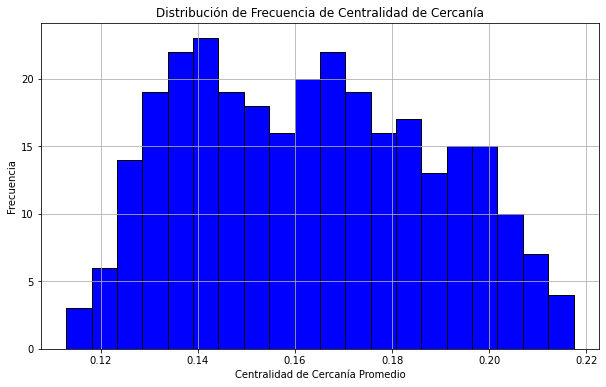

In [22]:
# Crear un histograma de la distribución de frecuencia de las centralidades
plt.figure(figsize=(10, 6))
plt.hist(centralidades_promedio, bins=20, color='blue', edgecolor='black')
plt.xlabel('Centralidad de Cercanía Promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencia de Centralidad de Cercanía')
plt.grid(True)
plt.show()


In [23]:
# Crear un diccionario de nodos y sus centralidades promedio
diccionario_centralidades = {nodo: centralidad for nodo, centralidad in zip(nodos, centralidades_promedio)}

# Obtener los 20 nodos con mayor centralidad de cercanía
nodos_top_20 = top(diccionario_centralidades)[:20]

# Mostrar la tabla de centralidades de grado para los nodos top 20
print("\nTabla de Centralidades de Grado para los Top 20 Nodos:")
print("Nodo\t\tCentralidad de Cercanía Promedio Promedio")
for nodo in nodos_top_20:
    print(f"{nodo}\t\t{diccionario_centralidades[nodo-3]}") 


Tabla de Centralidades de Grado para los Top 20 Nodos:
Nodo		Centralidad de Cercanía Promedio Promedio
128		0.2173769601961841
129		0.21301040634584603
114		0.21271055026464938
112		0.21256024902963597
111		0.21125605758422095
136		0.2106889590867916
150		0.21051166762362994
149		0.20998446262728684
148		0.2098088223599428
113		0.20925366497084846
130		0.20859319054143696
290		0.20632236490357506
173		0.20631203521415703
110		0.2061124757686045
162		0.20603082452541233
127		0.20441527607779034
126		0.20269687474246287
146		0.20261793764801167
115		0.20217348416196934
163		0.2021496648419639


# El programa calcula y muestra la centralidad de intermediacion de cada nodo en las redes, representado en un gráfico de líneas.

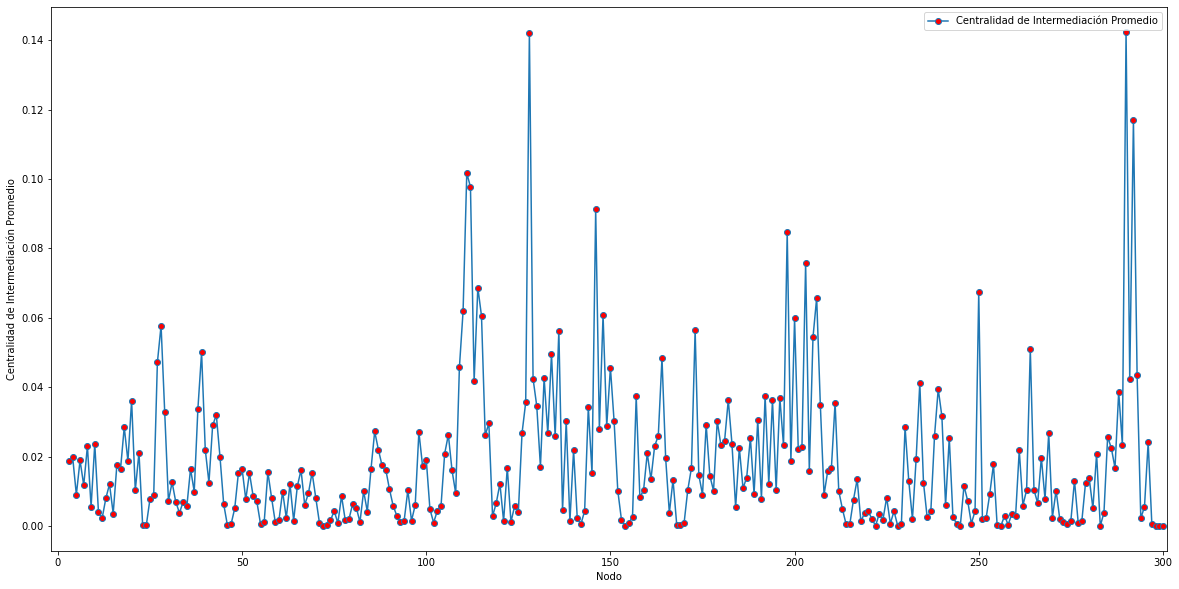

In [24]:
nodos = redes[0].nodes()  # Obtener la lista de nodos de una de las redes
centralidades_promedio = []

for nodo in nodos:
    centralidades_nodo = [nx.betweenness_centrality(red)[nodo] for red in redes]  # Obtener las centralidades de intermediación del nodo en cada red
    centralidad_promedio = np.mean(centralidades_nodo)
    centralidades_promedio.append(centralidad_promedio)
# Reetiquetar los números de nodo sumando 3 unidades
nodos_reetiquetados = [nodo + 3 for nodo in nodos]
plt.figure(figsize=(20, 10))
plt.ylabel('Centralidad de Intermediación Promedio')
plt.xlabel('Nodo')
plt.xlim(-2, 301)
plt.plot(nodos_reetiquetados, centralidades_promedio, '-o', mfc="r", label="Centralidad de Intermediación Promedio")
plt.legend()
plt.savefig('Centralidad de Intermediación Promedio', dpi=200)
plt.show()


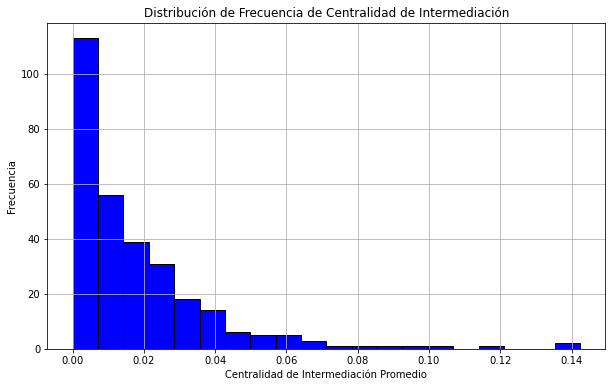

In [25]:
# Crear un histograma de la distribución de frecuencia de las centralidades
plt.figure(figsize=(10, 6))
plt.hist(centralidades_promedio, bins=20, color='blue', edgecolor='black')
plt.xlabel('Centralidad de Intermediación Promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencia de Centralidad de Intermediación')
plt.grid(True)
plt.show()

In [26]:
# Crear un diccionario de nodos y sus centralidades promedio
diccionario_centralidades = {nodo: centralidad for nodo, centralidad in zip(nodos, centralidades_promedio)}

# Obtener los 20 nodos con mayor grado de intermediación
nodos_top_20 = top(diccionario_centralidades)[:20]
    
# Mostrar la tabla de centralidades de grado para los nodos top 20
print("\nTabla de Centralidades de Grado para los Top 20 Nodos:")
print("Nodo\t\tCentralidad de Intermediación Promedio")
for nodo in nodos_top_20:
    print(f"{nodo}\t\t{diccionario_centralidades[nodo-3]}") 


Tabla de Centralidades de Grado para los Top 20 Nodos:
Nodo		Centralidad de Intermediación Promedio
290		0.14236207979242502
128		0.14211780177535763
292		0.1169473189212107
111		0.10166485674323424
112		0.09775091526214742
146		0.09122699206439981
198		0.08477448680281219
203		0.07567200586882655
114		0.06871699284903109
250		0.06730658016263964
206		0.0657570707904482
110		0.061937433716896646
148		0.06080319612473218
115		0.060531877070575946
200		0.0598452567182791
28		0.057763718611782644
173		0.05652297008050175
136		0.056259655386189766
205		0.05439611963152384
264		0.05095761182941865


# El programa calcula y muestra la centralidad de eigenvector de cada nodo en las redes, representado en un gráfico de líneas.


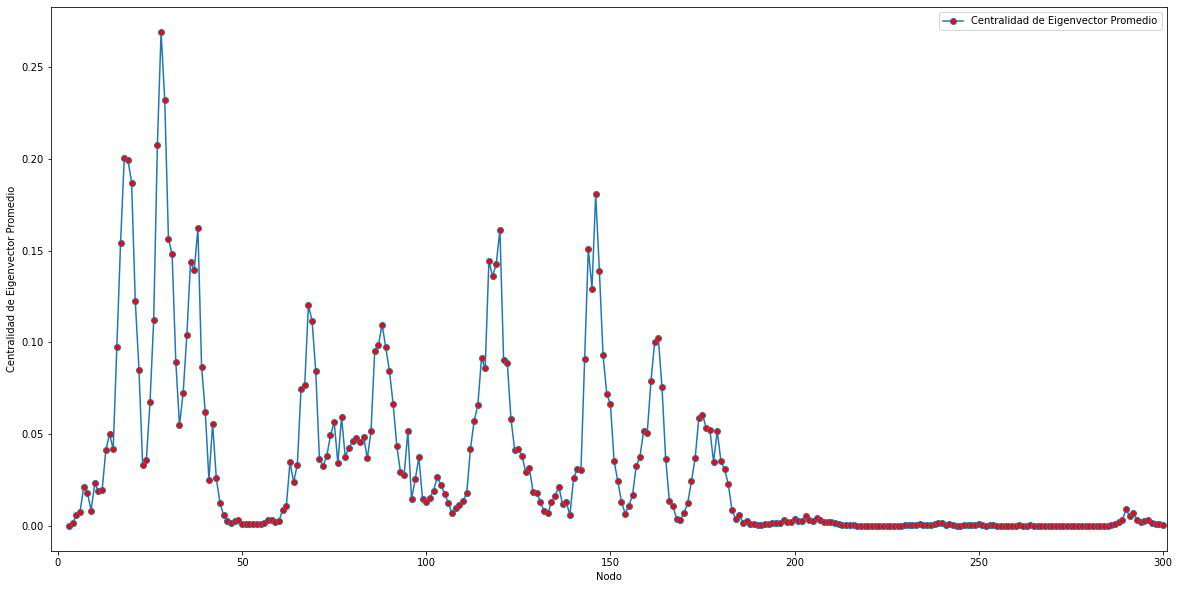

In [27]:
nodos = redes[0].nodes()  # Obtener la lista de nodos de una de las redes
centralidades_promedio = []

for nodo in nodos:
    centralidades_nodo = []
    for red in redes:
        try:
            centralidad = nx.eigenvector_centrality(red, max_iter=500)[nodo]  # Obtener la centralidad de eigenvector del nodo en cada red
            centralidades_nodo.append(centralidad)
        except nx.PowerIterationFailedConvergence:
            print(f"Convergencia fallida para el nodo {nodo} en una de las redes")
            continue
    
    if centralidades_nodo:
        centralidad_promedio = np.mean(centralidades_nodo)
        centralidades_promedio.append(centralidad_promedio)
# Reetiquetar los números de nodo sumando 3 unidades
nodos_reetiquetados = [nodo + 3 for nodo in nodos]
plt.figure(figsize=(20, 10))
plt.ylabel('Centralidad de Eigenvector Promedio')
plt.xlabel('Nodo')
plt.xlim(-2, 301)
plt.plot(nodos_reetiquetados, centralidades_promedio, '-o', mfc="r", label="Centralidad de Eigenvector Promedio")
plt.legend()
plt.savefig('Centralidad de Eigenvector Promedio', dpi=200)
plt.show()

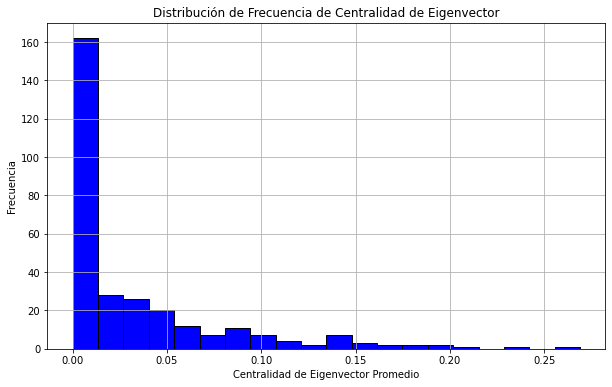

In [28]:
# Crear un histograma de la distribución de frecuencia de las centralidades
plt.figure(figsize=(10, 6))
plt.hist(centralidades_promedio, bins=20, color='blue', edgecolor='black')
plt.xlabel('Centralidad de Eigenvector Promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencia de Centralidad de Eigenvector')
plt.grid(True)
plt.show()

In [29]:
# Crear un diccionario de nodos y sus centralidades promedio
diccionario_centralidades = {nodo: centralidad for nodo, centralidad in zip(nodos, centralidades_promedio)}

# Obtener los 20 nodos con mayor centralidad de eigenvector
nodos_top_20 = top(diccionario_centralidades)[:20]
    
# Mostrar la tabla de centralidades de grado para los nodos top 20
print("\nTabla de Centralidades de Grado para los Top 20 Nodos:")
print("Nodo\t\tCentralidad de Eigenvector Promedio")
for nodo in nodos_top_20:
    print(f"{nodo}\t\t{diccionario_centralidades[nodo-3]}")     



Tabla de Centralidades de Grado para los Top 20 Nodos:
Nodo		Centralidad de Eigenvector Promedio
28		0.2690326587045157
29		0.2318891049442748
27		0.2076856903475867
18		0.20021152338262097
19		0.19936393195576896
20		0.18704680119615136
146		0.18056300346302862
38		0.1620967525345548
120		0.16143791424532086
30		0.15638197326581468
17		0.15396812267472595
144		0.15086021257071652
31		0.1479555882072877
117		0.14405325037201425
36		0.14389410592001017
119		0.14254063072919104
37		0.13920183592706242
147		0.13910452693931247
118		0.1362244917627445
145		0.12928359403649367
